## Longitudinal motion


Useful link (however the formulas used are not included here): http://kli.web.cern.ch/kli/USPAS_Lectures_Collective_Effects/Lectures/USPAS_01c_longitudinal_dynamics.pdf [2]

### LHC main parameters 
https://cds.cern.ch/record/304825/files/p61.pdf [1]

In [27]:
import sys
from math import *
import numpy as np
import pandas as pd
from dotted_dict import DottedDict
import matplotlib.pyplot as plt
import NAFFlib as pnf
sys.path.append('./utils')
from my_elements import *

### Plotting parameters

In [28]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [ ]:
def prepere_longitudinal_motion(m0, c, C0, E_0, gamma_tr, sigma_delta_madx, rf): # no dispersion included, this should go to functions
    
    # 1. Estimate the parameters of the relativistic particles
    E_rest = m0 # [eV]
    P0_C = np.sqrt(E_0**2-E_rest**2)  # Acutally it is P0*C --> reference momentum times the speed of ligth --> [eV]
    gamma_0 =  E_0/E_rest # gamma realtivistic of the reference particle  # crosscheckd with mad
    beta_0 = np.sqrt(1-1/gamma_0**2) # beta realtivistic of the reference particle
    f_rev_0 = (beta_0*c)/C0 # revolution frequency [Hz]
    T_rev_0 = 1/f_rev_0 # revolution period [s]
    
    # 2. Estimate synchrotron parameters
    alpha_c = (1/(gamma_tr**2)) # compaction factor
    eta = alpha_c - 1/(gamma_0**2)  # slip factor
    
    if eta < 0 : 
        phi_s = np.pi
    else:
        phi_s = 0
    
    # 3. Estimate the harmonic number
    h_float  = rf.f_RF/ f_rev_0
    h = int(rf.f_RF/ f_rev_0) 
   
    
    # 4. Calculate theoretically the synchrotron tune
    Q_s = np.sqrt(rf.V_RF*eta*h/(2*np.pi*E_0*(beta_0**2)) * np.cos(phi_s))
    
    # 5. Matching
    sigma_delta = sigma_delta_madx/(beta_0**2) # rms bunch length in [m]
    beta_z = C0*eta/(2*np.pi*Q_s) #[m]
    sigma_z = beta_z * sigma_delta
    
    
    my_dict = DottedDict()
    my_dict.eta = eta
    my_dict.P0_C = P0_C
    my_dict.beta_0 = beta_0
    my_dict.sigma_z = sigma_z
    my_dict.sigma_delta = sigma_delta
    
    return my_dict

### Constants

In [6]:
m0 = 0.9382720813 # proton rest mass, [GeV/c^2] 
c = 299792458 # speed of light [m/s]
C0 = 26658.8832 # LHC circumference MAD-X twiss, [m]   , alternively use 26659 [m]

### Parameters of the reference particle

In [7]:
E_rest = m0 # [GeV]
E_0 = 7000. # total energy of the reference particle [GeV]
P0 = np.sqrt(E_0**2-E_rest**2)  # Acutally it is P0*C --> reference momentum times the speed of ligth --> [GeV]
gamma_0 =  E_0/E_rest # gamma realtivistic of the reference particle  # crosscheckd with mad
beta_0 = np.sqrt(1-1/gamma_0**2) # beta realtivistic of the reference particle
f_rev_0 = (beta_0*c)/C0 # revolution frequency [Hz]
T_rev_0 = 1/f_rev_0 # revolution period [s]

### Synchrotron parameters
- $\eta > 0 $ : above transition
- $\eta < 0 $ : below transition
Usually for high energy beam we are above transition
- Stability cretirion according to [2]:
     - $\phi = \pi $ below transition ($\eta < 0$)
     - $\phi = 0 $ below transition ($\eta > 0$)

In [8]:
gamma_tr =  53.7102749510076 # MAD-X twiss
alpha_c = (1/(gamma_tr**2)) # compaction factor
eta = alpha_c - 1/(gamma_0**2)  # slip factor
print('eta = {}'.format(eta))
if eta < 0 : 
    print('below transition')
    phi_s = np.pi
else:
    print('above transition')
    phi_s = 0

eta = 0.00034662727979926824
above transition


### Define the parameters of the RF cavity
1) Give the values of the parameters

2) Plot the cavity voltage for phase from 0-2π

In [9]:
V_RF = 16e-3 # [GV]
lag = 180.#  the lag angle of the cavity [degrees], also known as phi_RF. If set up properly phi_RF = phi_s (synchronous phase) 
f_RF = 400.8e6 # Hz

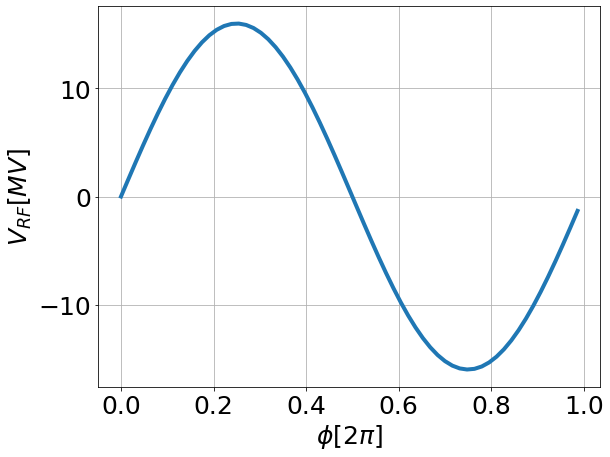

In [10]:
step = 0.1
phase_list =  np.arange(0, 2*np.pi, step) 
cavity_voltage = V_RF*1e3*np.sin( lag * np.pi / 180. - phase_list) # RF energy kick 

fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.plot(phase_list/(2*np.pi), cavity_voltage, linewidth = 4)
ax.set_xlabel(r'$\phi [2 \pi]$')
ax.set_ylabel(r'$V_{RF} [MV]$')
plt.grid()

### Calculate the harmonic number

In [11]:
h_float  = f_RF/ f_rev_0
h = int(f_RF/ f_rev_0) 
print('The harmonic number is h={}'.format(h))
print('float h ={}'.format(h_float))

The harmonic number is h=35640
float h =35640.92490460356


### Estimate theoretically the syncrhroton tune  (small amplitude approximation)
For particles close to the sunchroneous phase the definition of the synchrotron tune is :
\begin{equation}
Q_s = \frac{\omega_s}{\omega_0} = \sqrt{\frac{V_{RF} \eta h}{2 \pi E_0 \beta_0^2} \cos(\phi_s)}
\end{equation}
, where $V_{RF}$ the voltage of the RF in [GV], $\eta$ the slip factor, h the harmonic number, E_0 the total energy in [GeV], $\beta_0$ the relativistic beta of the reference particle and $\phi_s$ the fixed RF phase (wich is known as the synchronous phase).
- Stability cretirion according to [2]:
     - $\phi_s = \pi $ below transition ($\eta < 0$)
     - $\phi_s = 0 $ below transition ($\eta > 0$)

In [12]:
Q_s = np.sqrt(V_RF*eta*h/(2*np.pi*E_0*(beta_0**2)) * np.cos(phi_s))
print(Q_s)

0.0021199287183640224


### Stationary RF buncket parameters

1) bucket length [m] :
\begin{equation}
length = \frac{c}{f_{RF}}
\end{equation}
, where c is the speed of light in [m/s] and $f_R{RF}$ the frequency of the RF cavity in [Hz]

2) max bucket height (if you don't want the maximum, replace beta_0 with beta (maybe))
\begin{equation}
height = \beta_0 \frac{2 V_{RF}}{ \pi h \eta E_0}
\end{equation}




In [13]:
bucket_length = c/f_RF # [m]
max_bucket_height = beta_0*np.sqrt((2*V_RF)/(np.pi*h*eta*E_0)) # no units

### Limits of RF stationary bucket 
Assuming that is centered around 0 


1) Bunch length. c [m/s], f_RF [Hz]

In [14]:
z_left = - bucket_length/2. # [m]
z_right =  bucket_length/2. # [m]

### Plot the RF bucket

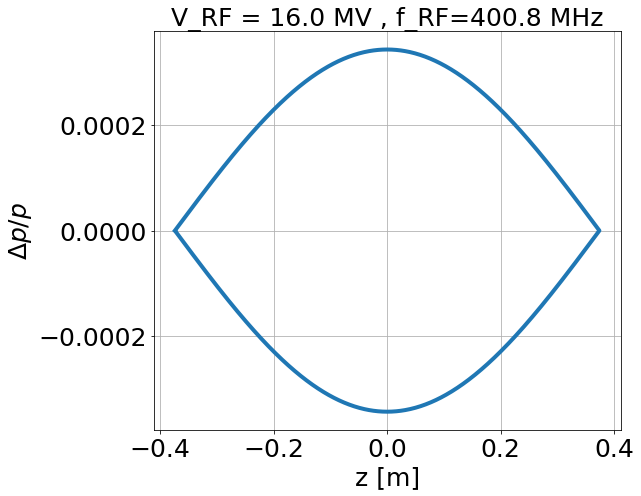

In [15]:
fig, ax = plt.subplots(1,1,figsize=(9,7))

step = 0.001
z_list = []
delta_list = []

for zi in np.arange(z_left , z_right , step):
    delta_list.append(np.sqrt(V_RF * (np.cos(h * zi * 2 * np.pi / C0) + 1.) / (np.pi * h * abs(eta) * beta_0 * P0)))
    z_list.append(zi)
                      
for zi in np.arange(z_right, z_left , -step):
    delta_list.append(-np.sqrt(V_RF * (np.cos(h * zi * 2 * np.pi / C0) + 1.) / (np.pi * h * abs(eta) * beta_0 * P0)))
    z_list.append(zi)

ax.plot(z_list, delta_list, linewidth =4)
plt.xlabel('z [m]')
plt.ylabel(r'$\Delta p / p$')
plt.title('V_RF = {} MV , f_RF={:.1f} MHz'.format(V_RF*1e3, f_RF*1e-6))

plt.grid()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('./figures/RF_bucket_V_RF{}MV_f_RF{:.1f}MHz_lagRF{}_sigma_z{}_sigma_d{}_E0{}_gammat_tr{:.3f}.png'.format(V_RF*1e3, f_RF*1e-6, lag, sigma_z, sigma_delta, E_0, gamma_tr))

### Matching 
- It is important to have a matched distribution to prevent filamentation i.e. emittance increase.
- The matching condition is the following :
\begin{equation}
\sigma_z = \beta_z \sigma_{\delta}
\end{equation},
where $\sigma_{\delta}$ the rms energy spread of the bunch and $\beta_z$ the longitudinal beta function (Courant- Snyder) [m] given by:
\begin{equation}
\beta_z  = \frac{C_0 |\eta_p|}{2 \pi Q_s}
\end{equation}
, where $C_0$ the circumference of the storage ring in [m] and $Q_s$ the synchrotron tune.

In [16]:
beta_z = C0*eta/(2*np.pi*Q_s) #[m]
print('beta_z = {} [m]'.format(beta_z))

beta_z = 693.7509076156513 [m]


### From MAD-X for HL-LHC at 7TeV
path to script cernbox/2019/7/HL_LH_mask_emilia.ipynb

- $\sigma_E/E = $ 0.00011

- But
\begin{equation}
\frac{dp}{p} = \frac{1}{\beta_0^2} \frac{dE}{E}
\end{equation}
, where $\beta_0$ the relativistic beta of the reference particle.

Therefore:
\begin{equation}
\sigma_{\delta} = \frac{\sigma_E}{E} \frac{1}{\beta^2}
\end{equation}

In [17]:
sigma_delta =  0.00011/(beta_0**2) # [m] rms relative momentum spread ,aune it should ne times not /?

In [18]:
sigma_z = beta_z * sigma_delta # rms bunch length in [m]
print('sigma_z = {} [m]'.format(sigma_z)) # from [1] sigma_z = 0.075 so the value we obtain is pretty similar

sigma_z = 0.07631260120878575 [m]


### Create the bunch 
Gaussian distribution 

In [19]:
n_particles = 1000
# create bunch
bunch = DottedDict()
bunch.z = np.zeros(n_particles)
bunch.delta = np.zeros(n_particles)
mu, sigma = 0.0, 1 # mean and standard deviation

z_initial = np.random.normal(mu, sigma, n_particles)*sigma_z
delta_initial = np.random.normal(mu, sigma, n_particles)*sigma_delta


bunch.z = z_initial
bunch.delta = delta_initial

In [20]:
bunch.z = z_initial
bunch.delta = delta_initial
df = pd.DataFrame({'turn':[], 'z':[], 'delta':[], 'y':[], 'py':[]})
# Append the initial values, not normalised
df = df.append({'turn':0, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)

### Tracking and plotting of the phase space

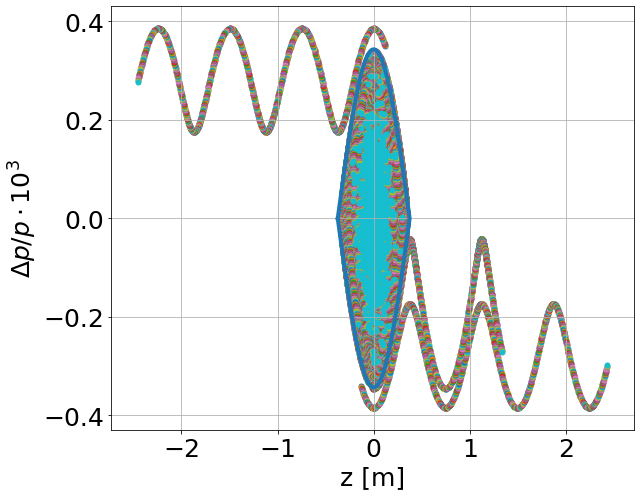

In [21]:
fig, ax = plt.subplots(1,1,figsize=(9,7))

turns = 1000
for turn in range(0, turns):
    ax.scatter(bunch.z, bunch.delta*1e3)
    ax.set_xlabel('z [m]')
    ax.set_ylabel(r'$\Delta p /p \cdot 10^3 $')
    bunch.z, bunch.delta = drift(eta, C0, bunch.z, bunch.delta)
    bunch.z, bunch.delta = RF_map(P0, m0, beta_0, f_RF, c, lag, V_RF, E_0, bunch.z, bunch.delta)
    
    df = df.append({'turn':turn, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)    
    
ax.plot(z_list, np.array(delta_list)*1e3, linewidth =4)    
plt.grid()
#plt.ylim(-2, 2)
plt.tight_layout()

save_data = False
savefig = False

if savefig:
    plt.savefig('./figures/phase_space_V_RF{}MV_f_RF{:.1f}MHz_lagRF{}_sigma_z{}_sigma_d{}_E0{}_gamma_tr{:.3f}_particles{}_turns{}.png'.format(V_RF*1e3, f_RF*1e-6, lag, sigma_z, sigma_delta, E_0, gamma_tr, n_particles, turns))
if save_data:
    df.to_pickle('V_RF{}MV_f_RF{:.1f}MHz_lagRF{}_sigma_z{}_sigma_d{}_E0{}_gammat_tr{:.3f}_particles{}_turns{}.pkl'.format(V_RF*1e3, f_RF*1e-6, lag, sigma_z, sigma_delta, E_0, gamma_tr, n_particles, turns))

### Estimate synchroton tune using NAFF
The particles that are lost are excluded

In [22]:
z_data = {}
delta_data = {}
for particle in range(n_particles):
    z_data[particle] = []
    delta_data[particle] = []

In [23]:
for particle in range(n_particles):
    for turn in range(turns):
        z_data[particle].append(df.at[turn,'z'][particle])
        delta_data[particle].append(df.at[turn,'delta'][particle])

In [24]:
lost_particles = []
Qs_list = []

for particle in range(n_particles):
    if np.isnan(z_data[particle]).any() or np.isnan(delta_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_z = z_data[particle]  
       
        Qs_list.append(pnf.get_tune(np.array(signal_z)))

### Calculate the average action for each particle over the number of turns

In [25]:
# the indeces 1, 2 corrsepond to the first and second time integral respectively
flag_average_actions = True
if flag_average_actions:
    Jz_mean = [] # Here you will save the average actions for each particle for every turn
    Jz_data = {}
    for particle in range(n_particles):
        Jz_data[particle] = []
        Jz_data[particle] = (np.array(z_data[particle])/sqrt(beta_z))**2 + (np.array(delta_data[particle])*sqrt(beta_z))**2
        Jz_mean.append(np.nanmean(Jz_data[particle]))

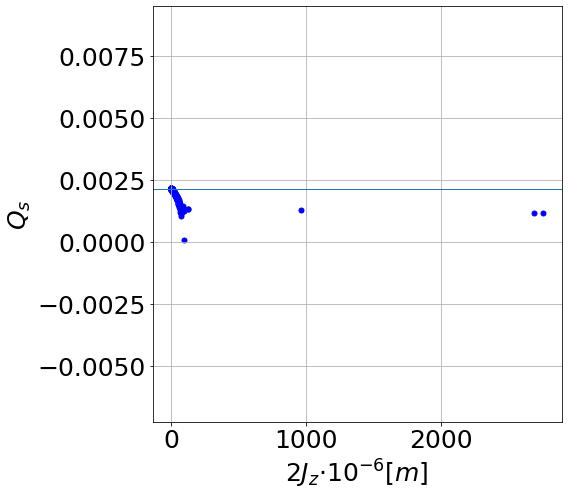

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,7))


ax.scatter(np.array(Jz_mean)*1e6, Qs_list, c='b', label=r'$Q_x$') 
ax.set_xlabel(r'$2J_z$'+r'$\cdot 10^{-6} [m]$')
ax.set_ylabel(r'$Q_s$')
#ax.set_xlim(0,1000)
ax.grid()
ax.axhline(Q_s, 0, 60)
plt.tight_layout()

savefig = False
if savefig:
    plt.savefig('./figures/tune_spread_V_RF{}MV_f_RF{:.1f}MHz_lagRF{}_sigma_z{}_sigma_d{}_E0{}_gammat_tr{:.3f}.png'.format(V_RF*1e3, f_RF*1e-6, lag, sigma_z, sigma_delta, E_0, gamma_tr))

#### Find the particle with the largest average of longitudinal actions

In [61]:
index_max = Jz_mean.index(max(Jz_mean))

### Evolution of the momentum deviation over time

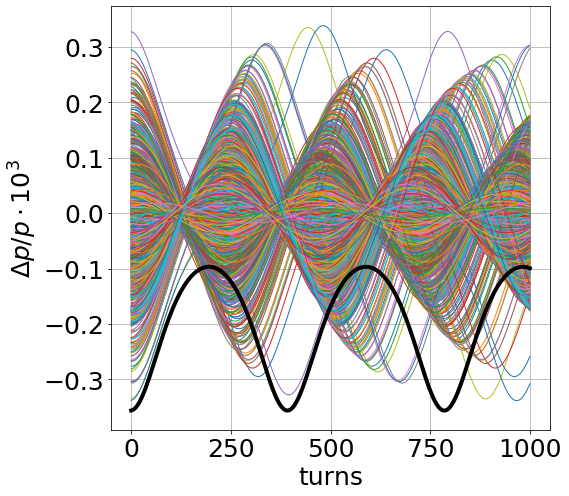

In [62]:
turns_list = np.arange(0,turns)

fig, ax = plt.subplots(1,1,figsize=(8,7))

for particle in range(n_particles):
    ax.plot(turns_list, np.array(delta_data[particle])*1e3)

ax.plot(turns_list, np.array(delta_data[index_max])*1e3, linewidth = 4, c = 'k')

ax.set_xlabel('turns')
ax.set_ylabel(r'$\Delta p /p \cdot 10^3 $')

ax.grid()
plt.tight_layout()

savefig = False
if savefig:
    plt.savefig('./figures/delta_vs_time_V_RF{}MV_f_RF{:.1f}MHz_lagRF{}_sigma_z{}_sigma_d{}_E0{}_gammat_tr{:.3f}.png'.format(V_RF*1e3, f_RF*1e-6, lag, sigma_z, sigma_delta, E_0, gamma_tr))